Here I am using toy naive examples and tests. The data sets are just Gaussian sequences. Here $Y_{T + 1}$ is rejected if  $$|Y_{T + 1}| > Q_{1 - \alpha}\{|Y_1|, |Y_2|, \dots, |Y_{T + 1}|\}.$$

I am not sure about how to do test in streaming settings, so what I wrote here can be completely wrong. Also some functions are quite slow. Feel free to make any modification if you want. 

(The running time of this notebook is approximately 10 mins.) 

# Helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def Gau_seq(T, r, sd1, sd2, loc = 0):
    """
    Generate a sequence of Gaussian variables of length T.
    
    :param T: length of sequence
    :param r: ratio of outliers
    :param sd1: standard deviation of inliers
    :param sd2: standard deviation of outliers
    :param loc: mean of outliers
    
    :return: a numpy vector of data
    
    """
    #Indicators with z = 1 for outliers
    z = np.random.uniform(0, 1, T) < r
    
    #Generate the sequence
    seq = np.random.normal(0, sd1, T) * (1 - z) + np.random.normal(loc, sd2, T) * z
    
    return(seq, z)
            
    

In [2]:
def Test(seq, alpha = 0.05):
    """
    Test if Y_T is an outlier. Under null hypothesis, we know 
        |Y_T| \le Q_{1 - \alpha}(|Y_1|, \dots, Y_T)
        
    We return TURE is Y_T is an outlier
    """
    abs_seq = abs(seq)
    
    comparison = abs_seq < abs_seq[-1]
    
    return( sum(comparison) > (1 - alpha) * len(seq) )

# Part(a)

Does the presence of outlier(s) before time $t$, tend to cause us to be more conservative or less conservative for detecting an outlier at time $t$, in practice?

In [3]:
def part_a(T = 100, r = 0.2, sd1 = 1, sd2 = 3, loc = 0, seed = 123, N = 200):
    """
    Do experiments for N times and compute power and type 1 error with method in part(a)
    
    :param T: length of sequence
    :param r: ratio of outliers
    :param sd1: standard deviation of inliers
    :param sd2: standard deviation of outliers
    :param loc: mean of outliers
    :param seed: a random seet
    :param N: number of repeated trials
    """
    np.random.seed(seed)
    
    results_out = np.zeros(N)
    results_in = np.zeros(N)
    
    for i in range(0, N):
        #Generate a sequence
        X, z = Gau_seq(T, r, sd1, sd2, loc)
        
        #X_{T+1} is an outlier
        outlier = np.random.normal(loc, sd2, 1)
        X_out = np.append(X, outlier)
        results_out[i] = Test(X_out)
 
        
        #X_{T+1} is an inlier
        inlier = np.random.normal(0, sd1, 1)
        X_in = np.append(X, inlier)
        results_in[i] = Test(X_in)
    
    return(sum(results_out)/N, sum(results_in)/N )
    
    

In [4]:
#Set different sd2 for outliers
sd2 = np.arange(0, 5.1, 0.1)
Power = np.zeros(len(sd2))
TypeI = np.zeros(len(sd2))

In [5]:
for i in range(0, len(sd2)):
    Power[i], TypeI[i] = part_a(T = 100, r = 0.2, sd1 = 1, sd2 = sd2[i], 
                                loc = 0, N = 500, seed =123)
    
    if i % 5 == 0:
        print( str((i + 1) / len(sd2) * 100) + "%" )

1.9607843137254901%
11.76470588235294%
21.568627450980394%
31.372549019607842%
41.17647058823529%
50.98039215686274%
60.78431372549019%
70.58823529411765%
80.3921568627451%
90.19607843137256%
100.0%


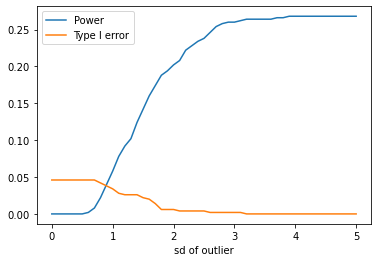

In [6]:
plt.plot(sd2, Power, label = "Power")
plt.plot(sd2, TypeI, label = "Type I error")
plt.xlabel("sd of outlier")

plt.legend();

# Part(b)

Are there ways to modify the procedure (i.e., the method of applying conformal prediction in a streaming way), to reduce any problems you've identified? For example, what if we try dropping any outliers -- say, if we reject at time ii and flag ($X_i$,$Y_i$) as an outlier, can we then drop this data point for future tests, like at time $i+1$ we compare ($X_{i+1},Y_{i+1}$)
 against $(X_1,Y_1),...,(X_{i-1},Y_{i-1})$? Would this "dropping" modification fix the problem, or might it introduce new issues?



Suppose we want to test if $X_{T+1}$ is an outlier. We implememnt this method and check its average performance under two scenarios:
1. No outliers
2. 20% of the data are outliers

In [7]:
def part_b(T = 100, r = 0.2, sd1 = 1, sd2 = 3, loc = 0, seed = 123, N = 200):
    """
    Do experiments for N times and compute power and type 1 error with method in part(b)

    
    :param T: length of sequence
    :param r: ratio of outliers
    :param sd1: standard deviation of inliers
    :param sd2: standard deviation of outliers
    :param loc: mean of outliers
    :param seed: a random seet
    :param N: number of repeated trials
    """
    np.random.seed(seed)
    
    results_in = np.zeros(N)
    results_out = np.zeros(N)
    for i in range(0, N):
        #Generate a sequence
        X, z = Gau_seq(T, r, sd1, sd2, loc)
        
        seq = np.array([X[0]]) #The data before time T that we do not drop
        for t in range(1, T):
            temp_seq = np.append(seq, X[t])
            if not Test(temp_seq):
                seq = temp_seq
        
        #X_{T+1} is an outlier
        outlier = np.random.normal(loc, sd2, 1)
        X_out = np.append(seq, outlier)
        results_out[i] = Test(X_out)
 
        
        #X_{T+1} is an inlier
        inlier = np.random.normal(0, sd1, 1)
        X_in = np.append(seq, inlier)
        results_in[i] = Test(X_in)
    
    return(sum(results_out)/N, sum(results_in)/N )

In [8]:
Ts = np.arange(40, 260, 20)
Power = np.zeros(len(Ts))
TypeI = np.zeros(len(Ts))

In [9]:
#Case when 20% of data are outliers
for i in range(0, len(Ts)):
    Power[i], TypeI[i] = part_b(T = Ts[i], r = 0.2, sd1 = 1, sd2 = 3, 
                                loc = 0, N = 500, seed =123)
    print( str((i + 1) / len(Ts) * 100) + "%" )

9.090909090909092%
18.181818181818183%
27.27272727272727%
36.36363636363637%
45.45454545454545%
54.54545454545454%
63.63636363636363%
72.72727272727273%
81.81818181818183%
90.9090909090909%
100.0%


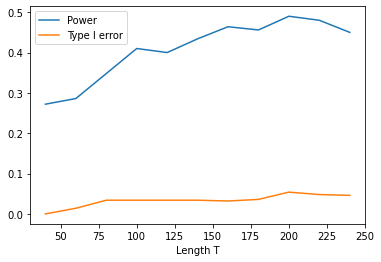

In [10]:
plt.plot(Ts, Power, label = "Power")
plt.plot(Ts, TypeI, label = "Type I error")
plt.xlabel("Length T")
plt.legend();


In [11]:
#Also look at method without dropping data
for i in range(0, len(Ts)):
    Power[i], TypeI[i] = part_a(T = Ts[i], r = 0.2, sd1 = 1, sd2 = 3, 
                                loc = 0, N = 500, seed = 123)
    print( str((i + 1) / len(Ts) * 100) + "%" )

9.090909090909092%
18.181818181818183%
27.27272727272727%
36.36363636363637%
45.45454545454545%
54.54545454545454%
63.63636363636363%
72.72727272727273%
81.81818181818183%
90.9090909090909%
100.0%


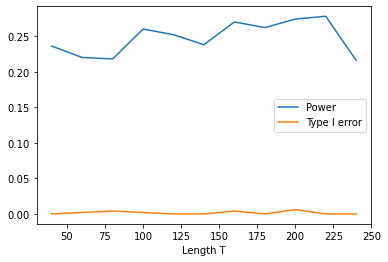

In [12]:
plt.plot(Ts, Power, label = "Power")
plt.plot(Ts, TypeI,  label = "Type I error")
plt.xlabel("Length T")
plt.legend();

In [13]:
#Case when  0% of data are outliers
for i in range(0, len(Ts)):
    Power[i], TypeI[i] = part_b(T = Ts[i], r = 0, sd1 = 1, sd2 = 3, 
                                loc = 0, N = 500, seed =123)
    print( str((i + 1) / len(Ts) * 100) + "%" )

9.090909090909092%
18.181818181818183%
27.27272727272727%
36.36363636363637%
45.45454545454545%
54.54545454545454%
63.63636363636363%
72.72727272727273%
81.81818181818183%
90.9090909090909%
100.0%


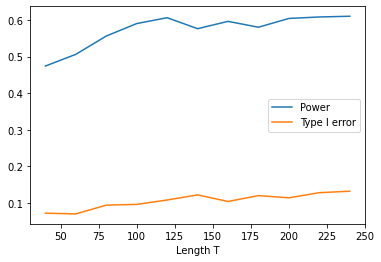

In [14]:
plt.plot(Ts, Power, label = "Power")
plt.plot(Ts, TypeI, label = "Type I error")
plt.xlabel("Length T")
plt.legend();


In [15]:
#Also look at method without dropping data
for i in range(0, len(Ts)):
    Power[i], TypeI[i] = part_a(T = Ts[i], r = 0, sd1 = 1, sd2 = 3, 
                                loc = 0, N = 500, seed =123)
    print( str((i + 1) / len(Ts) * 100) + "%" )

9.090909090909092%
18.181818181818183%
27.27272727272727%
36.36363636363637%
45.45454545454545%
54.54545454545454%
63.63636363636363%
72.72727272727273%
81.81818181818183%
90.9090909090909%
100.0%


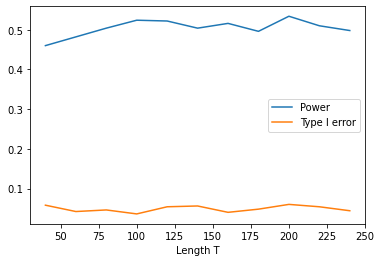

In [16]:
plt.plot(Ts, Power, label = "Power")
plt.plot(Ts, TypeI, label = "Type I error")
plt.xlabel("Length T")
plt.legend();


# Part (c)

## Modification 1:

As Karl suggested, each time we find an potential outlier,we drop it with some probability

In [17]:
def part_c_prob(T = 100, r = 0.2, sd1 = 1, sd2 = 3, loc = 0, seed = 123, alpha = 0.05, 
                prob = 0.05,
                N = 200):
    """
    Do experiments for N times and compute power and type 1 error with method in part(c)
    
    :param T: length of sequence
    :param r: ratio of outliers
    :param sd1: standard deviation of inliers
    :param sd2: standard deviation of outliers
    :param loc: mean of outliers
    :param seed: a random seet
    :param prob: probability of keeping an outlier
    :param N: number of repeated trials
    """
    np.random.seed(seed)
    
    results_in = np.zeros(N)
    results_out = np.zeros(N)
    for i in range(0, N):
        #Generate a sequence
        X, z = Gau_seq(T, r, sd1, sd2, loc)
        
        seq = np.array([X[0]]) #The data before time T that we do not drop
        for t in range(1, T):
            temp_seq = np.append(seq, X[t])
            if not Test(temp_seq):
                seq = temp_seq
            elif np.random.uniform(0, 1, 1) < prob:
                seq = temp_seq
        
        #X_{T+1} is an outlier
        outlier = np.random.normal(loc, sd2, 1)
        X_out = np.append(seq, outlier)
        results_out[i] = Test(X_out)
 
        
        #X_{T+1} is an inlier
        inlier = np.random.normal(0, sd1, 1)
        X_in = np.append(seq, inlier)
        results_in[i] = Test(X_in)
    
    return(sum(results_out)/N, sum(results_in)/N )

In [18]:
probs = np.arange(0, 1.05, 0.05)
Power = np.zeros(len(probs))
TypeI = np.zeros(len(probs))

In [19]:
#Case when 20% of data are outliers
for i in range(0, len(probs)):
    Power[i], TypeI[i] = part_c_prob(T = 100, r = 0.2, sd1 = 1, sd2 = 3, 
                                loc = 0, N = 500, prob = probs[i], seed =123)
    print( str((i + 1) / len(probs) * 100) + "%" )

4.761904761904762%
9.523809523809524%
14.285714285714285%
19.047619047619047%
23.809523809523807%
28.57142857142857%
33.33333333333333%
38.095238095238095%
42.857142857142854%
47.61904761904761%
52.38095238095239%
57.14285714285714%
61.904761904761905%
66.66666666666666%
71.42857142857143%
76.19047619047619%
80.95238095238095%
85.71428571428571%
90.47619047619048%
95.23809523809523%
100.0%


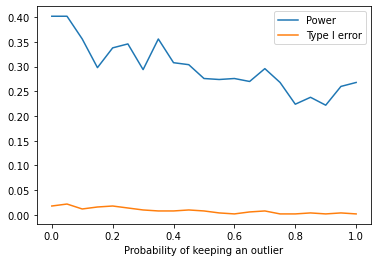

In [20]:
plt.plot(probs, Power, label = "Power")
plt.plot(probs, TypeI, label = "Type I error")
plt.xlabel("Probability of keeping an outlier")
plt.legend();

In [21]:
#Case when  0% of data are outliers
for i in range(0, len(probs)):
    Power[i], TypeI[i] = part_c_prob(T = 100, r = 0, sd1 = 1, sd2 = 3, 
                                loc = 0, N = 500, prob = probs[i], seed =123)
    print( str((i + 1) / len(probs) * 100) + "%" )

4.761904761904762%
9.523809523809524%
14.285714285714285%
19.047619047619047%
23.809523809523807%
28.57142857142857%
33.33333333333333%
38.095238095238095%
42.857142857142854%
47.61904761904761%
52.38095238095239%
57.14285714285714%
61.904761904761905%
66.66666666666666%
71.42857142857143%
76.19047619047619%
80.95238095238095%
85.71428571428571%
90.47619047619048%
95.23809523809523%
100.0%


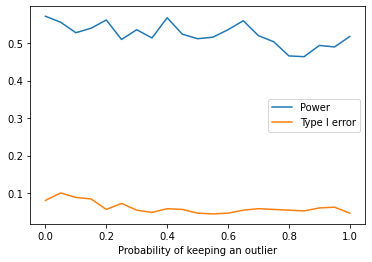

In [22]:
plt.plot(probs, Power, label = "Power")
plt.plot(probs, TypeI, label = "Type I error")
plt.xlabel("Probability of keeping an outlier")
plt.legend();

## Modification 2:

We can modify the Test procedure by a weighted average

In [23]:
def Test_weighted(seq, w, alpha = 0.05):
    """
    Test if Y_T is an outlier. Under null hypothesis, we know 
        |Y_T| \le Q_{1 - \alpha}(|Y_1|, \dots, Y_T)
        
    We return TURE is Y_T is an outlier
    """
    
    #Normalize weights
    w = w/sum(w)
    
    abs_seq = abs(seq)
    
    comparison = abs_seq < abs_seq[-1]
    
    return( sum(w * comparison) > (1 - alpha))

def part_c_weight(T = 100, r = 0.2, sd1 = 1, sd2 = 3, loc = 0, seed = 123, alpha = 0.05, 
                  w_out = 0.05, N = 200):
    """
    Do experiments for N times and compute power and type 1 error with method in part(c)
    
    :param T: length of sequence
    :param r: ratio of outliers
    :param sd1: standard deviation of inliers
    :param sd2: standard deviation of outliers
    :param loc: mean of outliers
    :param seed: a random seet
    :param w_out: weight ouf outlier
    :param N: number of repeated trials
    """
    np.random.seed(seed)
    
    results_in = np.zeros(N)
    results_out = np.zeros(N)
    for i in range(0, N):
        #Generate a sequence
        X, z = Gau_seq(T , r, sd1, sd2, loc)
        #Assign weights
        w = np.ones(T + 1)
        seq = np.array([X[0]]) #The data before time T that we do not drop
        for t in range(1, T):
            if Test_weighted(X[0:(t + 1)], w[0: (t + 1)]):
                w[t] = w_out
        
        #X_{T+1} is an outlier
        outlier = np.random.normal(loc, sd2, 1)
        X_out = np.append(X, outlier)
        results_out[i] = Test_weighted(X_out, w[0:(T+1)])
 
        
        #X_{T+1} is an inlier
        inlier = np.random.normal(0, sd1, 1)
        X_in = np.append(X, inlier)
        results_in[i] = Test_weighted(X_in, w[0:(T+1)])

    
    return(sum(results_out)/N, sum(results_in)/N )

In [24]:
ws = np.arange(0, 1.05, 0.05)
Power = np.zeros(len(ws))
TypeI = np.zeros(len(ws))

In [25]:
#Case when 20% of data are outliers
for i in range(0, len(ws)):
    Power[i], TypeI[i] = part_c_weight(T = 100, r = 0.2, sd1 = 1, sd2 = 3, 
                                loc = 0, N = 500, w_out = ws[i], seed =123)
    print( str((i + 1) / len(ws) * 100) + "%" )

4.761904761904762%
9.523809523809524%
14.285714285714285%
19.047619047619047%
23.809523809523807%
28.57142857142857%
33.33333333333333%
38.095238095238095%
42.857142857142854%
47.61904761904761%
52.38095238095239%
57.14285714285714%
61.904761904761905%
66.66666666666666%
71.42857142857143%
76.19047619047619%
80.95238095238095%
85.71428571428571%
90.47619047619048%
95.23809523809523%
100.0%


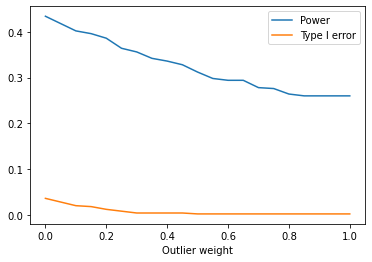

In [26]:
plt.plot(ws, Power, label = "Power")
plt.plot(ws, TypeI, label = "Type I error")
plt.xlabel("Outlier weight")
plt.legend();

In [27]:
#Case when  0% of data are outliers
for i in range(0, len(ws)):
    Power[i], TypeI[i] = part_c_weight(T = 100, r = 0, sd1 = 1, sd2 = 3, 
                                loc = 0, N = 500, w_out = ws[i], seed =123)
    print( str((i + 1) / len(ws) * 100) + "%" )

4.761904761904762%
9.523809523809524%
14.285714285714285%
19.047619047619047%
23.809523809523807%
28.57142857142857%
33.33333333333333%
38.095238095238095%
42.857142857142854%
47.61904761904761%
52.38095238095239%
57.14285714285714%
61.904761904761905%
66.66666666666666%
71.42857142857143%
76.19047619047619%
80.95238095238095%
85.71428571428571%
90.47619047619048%
95.23809523809523%
100.0%


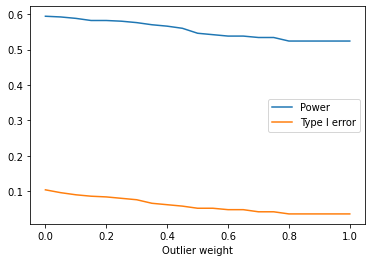

In [28]:
plt.plot(ws, Power, label = "Power")
plt.plot(ws, TypeI, label = "Type I error")
plt.xlabel("Outlier weight")
plt.legend();